# Your personal weekly top
Hi there! 😉  
This notebook creates a dataset from your scrobbles and then gives your top 10:  
- songs
- artists
- genres (tags)  
  
for the last week. 📊

In [60]:
import requests, json, time, pandas as pd, pprint
import seaborn as sns
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

In [64]:
@dataclass
class LastFM:
    basic_url: str = 'https://ws.audioscrobbler.com/2.0/'
    method: str = 'user.getrecenttracks'
    limit: int = 800
    page: int = 1
    api_key: str = ''
    user: str = ''
    
    def __post_init__(self):
        with open('creds.json') as f:
            creds = json.load(f)
            self.api_key = creds['apiKey']
            self.user = creds['username']
            
    
    def get_data(self) -> None:
        url = f'{self.basic_url}?method={self.method}&user={self.user}&api_key={self.api_key}&limit={self.limit}&page={self.page}&format=json'
        data = requests.get(url)
        data = data.json()['recenttracks']['track']
        data = self.form_dataset(data)
        return data
    
    def form_dataset(self, data):
        tracks = {}
        
        for i in data[1:]:
                if i['artist']['#text'] not in tracks:
                    tracks[i['artist']['#text']]={}
                    tracks[i['artist']['#text']]['tracks']=[[i['name'], i['date']['#text']]]
                else:
                    tracks[i['artist']['#text']]['tracks'].append([i['name'], i['date']['#text']])
                
        for i in tracks.keys():
            tag = self.get_artist_tags(i)
            if 'tags' not in tracks[i]:
                tracks[i]['tags'] = {}
                tracks[i]['tags'] = tag
            
        df = pd.DataFrame.from_dict(tracks, orient='index', columns=['tracks', 'tags'])
        df = df.rename_axis('artist').reset_index()
        df = df.explode('tracks')
        df[['tracks', 'date']] = df.tracks.apply(pd.Series)
        df.date = pd.to_datetime(df.date)
        # last 7 days
        df = df[(pd.Timestamp.today() - df.date).dt.days <= 7]
        # any wanted range of dates
#         df = df[((pd.Timestamp.today() - df.date).dt.days > 7)&((pd.Timestamp.today() - df.date).dt.days <= 21)]
        return df
    
    def get_artist_tags(self, artist, method='artist.getinfo'):
        url = f'{self.basic_url}?method={method}&artist={artist}&api_key={self.api_key}&format=json'
        data = requests.get(url).json()
        tags = []
        
        if 'artist' in data:
            for i in data['artist']['tags']['tag']:
                if i['name']!='seen live' and i['name']!='russian':
                    tags.append(i['name'])

        return tags
    
    def show_top_10_tracks(self, df):
        df['tracks'] = df[['artist', 'tracks']].agg(' - '.join, axis=1)
        df = df.tracks.value_counts()[:10]
        sns.set_style("whitegrid")
        sns.set(rc={'figure.figsize':(10, 10)})
        sns.barplot(x=df.values, y=df.index, palette="hls",
                    saturation=0.75, orient='h').set_title('My top tracks by last week',
                                                           fontdict = { 'fontsize': 20})
        
    def show_top_10_artists(self, df):
        df = df.artist.value_counts()[:10]
        sns.set_style("whitegrid")
        sns.set(rc={'figure.figsize':(10, 10)})
        sns.barplot(x=df.values, y=df.index, palette="hls",
                    saturation=0.75, orient='h').set_title('My top artists by last week',
                                                           fontdict = { 'fontsize': 20})
    
    def show_top_10_tags(self, df):
        df=df.tags.explode('tags').value_counts()[:10]
        sns.set_style("whitegrid")
        sns.set(rc={'figure.figsize':(10, 10)})
        sns.barplot(x=df.values, y=df.index, palette="hls",
                    saturation=0.75, orient='h').set_title('My top tags by last week',
                                                           fontdict = { 'fontsize': 20})

In [65]:
lfm = LastFM()

In [66]:
df = lfm.get_data()

In [67]:
df

,artist,tracks,tags,date
0,The Smiths,Back to the Old House,"[indie, 80s, post-punk, new wave, alternative]",2023-09-07 08:06:00
0,The Smiths,Bigmouth Strikes Again,"[indie, 80s, post-punk, new wave, alternative]",2023-09-04 07:38:00
0,The Smiths,"Please, Please, Please Let Me Get What I Want","[indie, 80s, post-punk, new wave, alternative]",2023-08-29 20:26:00
0,The Smiths,There Is a Light That Never Goes Out,"[indie, 80s, post-punk, new wave, alternative]",2023-08-29 20:23:00
0,The Smiths,Heaven Knows I'm Miserable Now,"[indie, 80s, post-punk, new wave, alternative]",2023-08-29 20:19:00
...,...,...,...,...
303,Источник,страх,"[indie, post-punk, emo, dream pop]",2023-08-28 06:39:00
304,Radiohead,A Wolf at the Door,"[alternative, alternative rock, rock, indie, e...",2023-08-28 06:27:00
305,Григорий Полухутенко,Всё сгорает,"[folk, acoustic, Acoustic Folk]",2023-08-28 06:24:00
306,Atlantida Project,Иордан,"[cyberfolk, female vocalists, folk, electronic]",2023-08-28 06:19:00


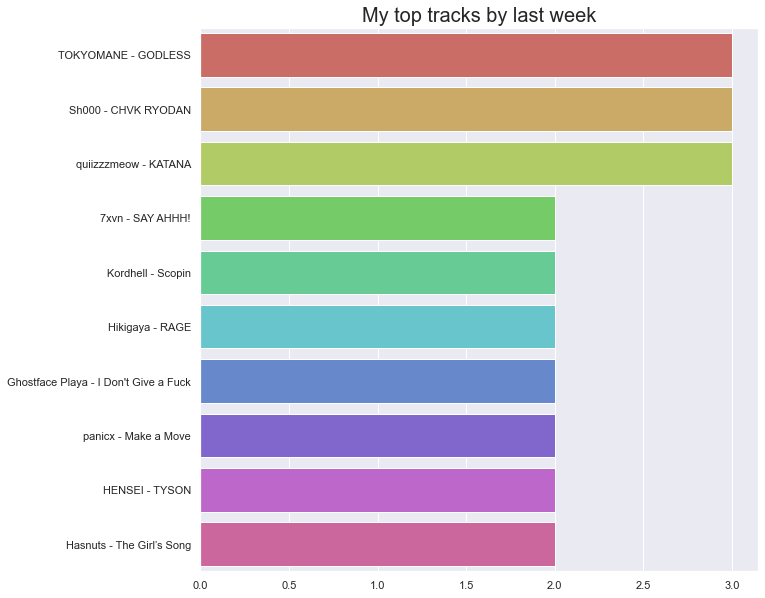

In [68]:
lfm.show_top_10_tracks(df)

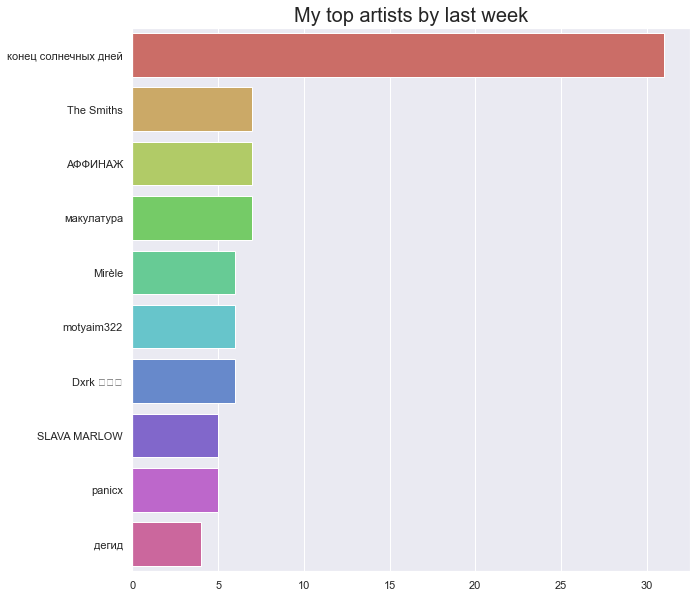

In [69]:
lfm.show_top_10_artists(df)

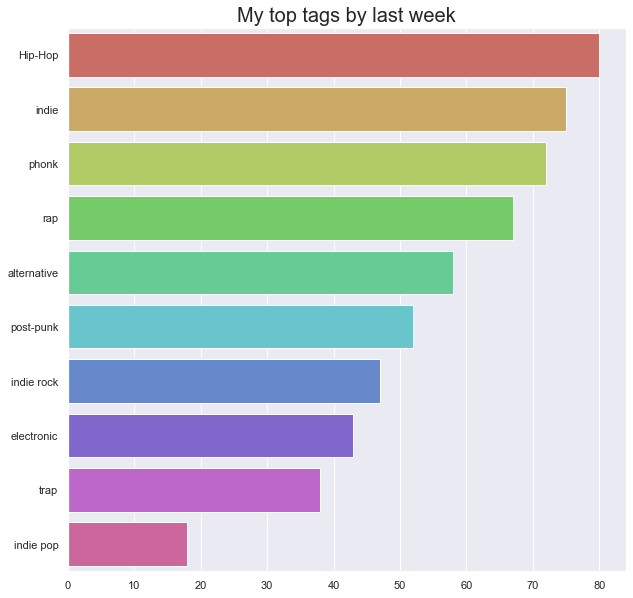

In [70]:
lfm.show_top_10_tags(df)